# Riborex Analysis T0, T1, T24 all interaction


In [1]:
suppressMessages(library(riborex))
suppressMessages(library(fdrtool))


annotations <- read.table(file.path('..', 'data', 'annotations', 'hg38_gene_names_stripped.tsv'), 
                          header=F, 
                          col.names = c('gene_id', 'gene_name', 'gene_type'))
rownames(annotations) <- annotations$gene_id

readcounts.dir <- file.path('..', 'data', 'read_counts', 'byCDS')
results.dir <- file.path('..', 'results', 'translation_efficiency')
rna.design.file <- file.path('..', 'data', 'design_files', 'rna_seq_design.tsv')
ribo.design.file <- file.path('..', 'data', 'design_files', 'ribo_seq_design.tsv')

## Suffix of htseq-count output
counts.suffix <- '.CDS.counts.tsv'

rna.design.info <- read.table(rna.design.file, header=T, stringsAsFactors=FALSE)
ribo.design.info <- read.table(ribo.design.file, header=T, stringsAsFactors=FALSE)
histone.genes.df <- read.table(file.path('..', 'data', 'annotations', 
                                         'histone_genes.tsv'), 
                               header = T, 
                               stringsAsFactors = F,
                               sep = '\t') 


histone.genes.1 <- annotations[grep('HIST', annotations$gene_name), ]$gene_id
histone.genes.2 <-annotations[annotations$gene_name %in% 
                                histone.genes.df$Approved.Symbol, ]$gene_id
# Add RP1-34B50.21 separately since symbol doesn't have HIST in it.
histone.genes <- unique(c(histone.genes.1, histone.genes.2, 'ENSG00000282988'))

count.reads <- function(design.info, dirname){
 files <- paste(design.info$SampleFile, counts.suffix, sep='')
 sampleName <- design.info$SampleName
 sampleTable <- data.frame(sampleName=sampleName, fileName=files)
 ddsHTSeq <- DESeqDataSetFromHTSeqCount(sampleTable = sampleTable, 
          directory = file.path(readcounts.dir, dirname),
          design = ~ 1)
 rownames(ddsHTSeq) <- gsub('\\.[0-9]+', '', rownames(ddsHTSeq))
 ddsHTSeq <- ddsHTSeq[ rowSums(counts(ddsHTSeq)) > 1, ]
 dds <- DESeq(ddsHTSeq)

     # Remove histones
 ddsHTSeq <- ddsHTSeq[!(rownames(ddsHTSeq) %in% histone.genes),]
 ddsHTSeq <- ddsHTSeq[ rowSums(counts(ddsHTSeq)) > 1, ]
 return(counts(dds))
}

write_results <- function(df, prefix){
 df<- as.data.frame(df)
 df <- df[order(df$padj),]
 df$gene_name <- annotations[rownames(df),]$gene_name
 df.sig <- subset(df, padj<0.05)
 df.sig.up <- subset(df.sig, log2FoldChange>0)
 df.sig.down <- subset(df.sig, log2FoldChange<0)
 write.table(df, 
             file = file.path(results.dir, paste(prefix, 'all', 'tsv', sep='.')),
             sep = '\t')
 write.table(df.sig, 
             file = file.path(results.dir, paste(prefix, 'sig', 'tsv', sep='.')),
             sep = '\t')
 write.table(df.sig.up, 
             file = file.path(results.dir, paste(prefix, 'sig', 'up', 'tsv', sep='.')),
             sep = '\t')
 write.table(df.sig.down, 
             file = file.path(results.dir, paste(prefix, 'sig', 'down', 'tsv', sep='.')),
             sep = '\t'
             )
 return (df.sig)
}

riborex.for.cellline <- function(rna.read.counts, ribo.read.counts, cell.line, contrast, merge.T1=FALSE){
 rna.read.counts <- rna.read.counts[, grepl(cell.line, colnames(rna.read.counts))]
 ribo.read.counts <- ribo.read.counts[, grepl(cell.line, colnames(ribo.read.counts))]
 rna.conditions.time <- as.factor(as.vector(sapply(colnames(rna.read.counts), function(x) unlist(strsplit(x, '_'))[3])))
 ribo.conditions.time <- as.factor(as.vector(sapply(colnames(ribo.read.counts), function(x) unlist(strsplit(x, '_'))[4])))
 rna.conditions.cell <- as.factor(as.vector(sapply(colnames(rna.read.counts), function(x) unlist(strsplit(x, '_'))[1])))
 ribo.conditions.cell <- as.factor(as.vector(sapply(colnames(ribo.read.counts), function(x) unlist(strsplit(x, '_'))[1])))
 
 if (merge.T1){
   levels(rna.conditions.time)[levels(rna.conditions.time)=='T0'] <- 'T0T1'
   levels(rna.conditions.time)[levels(rna.conditions.time)=='T1'] <- 'T0T1'
   levels(ribo.conditions.time)[levels(ribo.conditions.time)=='T0'] <- 'T0T1'
   levels(ribo.conditions.time)[levels(ribo.conditions.time)=='T1'] <- 'T0T1'
 }
 rna.conditions <- data.frame('time' = rna.conditions.time)
 ribo.conditions <- data.frame('time' = ribo.conditions.time)
 common.genes <- intersect(rownames(rna.read.counts), rownames(ribo.read.counts)) 
 rna.read.counts <- rna.read.counts[common.genes,]
 ribo.read.counts <- ribo.read.counts[common.genes,]
 colnames(rna.read.counts) <- paste(colnames(rna.read.counts), 'RNA', sep='_')
 colnames(ribo.read.counts) <- paste(colnames(ribo.read.counts), 'Ribo', sep='_')
 res <- riborex(rna.read.counts, 
        ribo.read.counts, 
        rna.conditions, 
        ribo.conditions, 
        contrast = contrast)
 return (res)
}
                                                    
                                                    
doPvalueAdjustment <- function(results){
  hist(results$pvalue,  main = 'DESeq2 unadjusted p-values', 
       xlab = 'Unadjusted p-values')
  results <- results[ !is.na(results$padj), ]
  results <- results[ !is.na(results$pvalue), ]
  results <- results[, -which(names(results) == 'padj')]
  resultsFDR <- fdrtool(results$stat, 
                        statistic= 'normal', 
                        plot = T)
  results[,'padj']  <- p.adjust(resultsFDR$pval,
                                method = 'BH')
  hist(resultsFDR$pval, 
       main = 'DESeq2 corrected p-values | Empirical null', 
       xlab = 'Corrected p-values')
  return (results)
}

In [2]:
                                                    


rna.read.counts.all <- count.reads(rna.design.info, 'RNA_seq')
ribo.read.counts.all <- count.reads(ribo.design.info, 'Ribo_seq')

rna.conditions.time.all <- as.factor(as.vector(sapply(colnames(rna.read.counts.all), function(x) unlist(strsplit(x, '_'))[3])))
ribo.conditions.time.all <- as.factor(as.vector(sapply(colnames(ribo.read.counts.all), function(x) unlist(strsplit(x, '_'))[4])))

rna.conditions.time.all.t0t1 <- rna.conditions.time.all
ribo.conditions.time.all.t0t1 <- ribo.conditions.time.all

levels(rna.conditions.time.all.t0t1)[levels(rna.conditions.time.all.t0t1)=='T0'] <- 'T0T1'
levels(rna.conditions.time.all.t0t1)[levels(rna.conditions.time.all.t0t1)=='T1'] <- 'T0T1'

levels(ribo.conditions.time.all.t0t1)[levels(ribo.conditions.time.all.t0t1)=='T0'] <- 'T0T1'
levels(ribo.conditions.time.all.t0t1)[levels(ribo.conditions.time.all.t0t1)=='T1'] <- 'T0T1'

rna.conditions.cell.all <- as.factor(as.vector(sapply(colnames(rna.read.counts.all), function(x) unlist(strsplit(x, '_'))[1])))
ribo.conditions.cell.all <- as.factor(as.vector(sapply(colnames(ribo.read.counts.all), function(x) unlist(strsplit(x, '_'))[1])))

rna.conditions.all <- data.frame('cell.type' = rna.conditions.cell.all, 
                                 'time' = rna.conditions.time.all)
ribo.conditions.all <- data.frame('cell.type' = ribo.conditions.cell.all, 
                                  'time' = ribo.conditions.time.all)

rna.conditions.all.t0t1 <- data.frame('cell.type' = rna.conditions.cell.all, 
                                      'time' = rna.conditions.time.all.t0t1)
ribo.conditions.all.t0t1 <- data.frame('cell.type' = ribo.conditions.cell.all, 
                                       'time' = ribo.conditions.time.all.t0t1)

common.genes <- intersect(rownames(rna.read.counts.all), rownames(ribo.read.counts.all)) 

rna.read.counts.all <- rna.read.counts.all[common.genes,]
ribo.read.counts.all <- ribo.read.counts.all[common.genes,]

colnames(rna.read.counts.all) <- paste(colnames(rna.read.counts.all), 'RNA', sep='_')
colnames(ribo.read.counts.all) <- paste(colnames(ribo.read.counts.all), 'Ribo', sep='_')

Warning message in DESeq(ddsHTSeq):
“the design is ~ 1 (just an intercept). is this intended?”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 20 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
Warning message in DESeq(ddsHTSeq):
“the design is ~ 1 (just an intercept). is this intended?”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 26 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [3]:
contrast.t1vst0 <- c('time', 'T1', 'T0')
contrast.t24vst0 <- c('time', 'T24', 'T0')
contrast.t24vst1 <- c('time', 'T24', 'T1')

contrast.t24vst0t1 <- c('time', 'T24', 'T0T1')

In [9]:
colnames(ribo.read.counts.all)

[1] "U251_TC1_0GY_T0_Ribo"  "U251_TC1_5GY_T1_Ribo"  "U251_TC1_5GY_T24_Ribo"
 [4] "U251_L2_0GY_T0_Ribo"   "U251_L2_5GY_T1_Ribo"   "U251_L2_5GY_T24_Ribo" 
 [7] "U251_L3_5GY_T1_Ribo"   "U251_L3_5GY_T24_Ribo"  "U343_L1_0GY_T0_Ribo"  
[10] "U343_L1_5GY_T1_Ribo"   "U343_L1_5GY_T24_Ribo"  "U343_L2_0GY_T0_Ribo"  
[13] "U343_L2_5GY_T1_Ribo"   "U343_L2_5GY_T24_Ribo"  "U343_L3_0GY_T0_Ribo"  
[16] "U343_L3_5GY_T1_Ribo"   "U343_L3_5GY_T24_Ribo"

# All T1 vs T0

DESeq2 mode selected
combining design matrix
applying DESeq2 to modified design matrix
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>


Step 1... determine cutoff point
Step 2... estimate parameters of null distribution and eta0
Step 3... compute p-values and estimate empirical PDF/CDF
Step 4... compute q-values and local fdr
Step 5... prepare for plotting


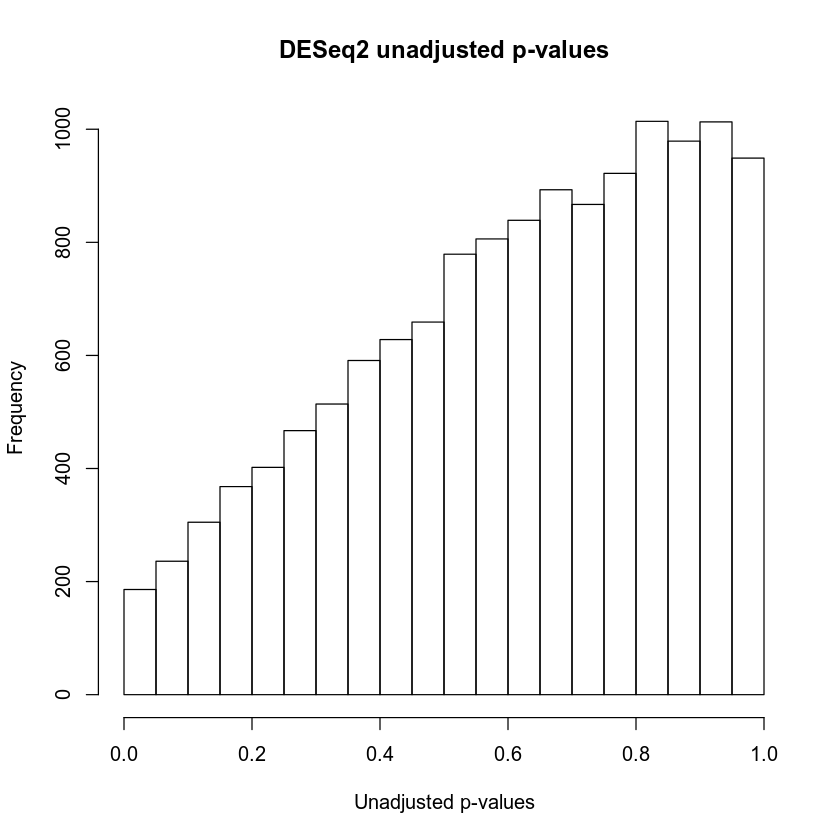

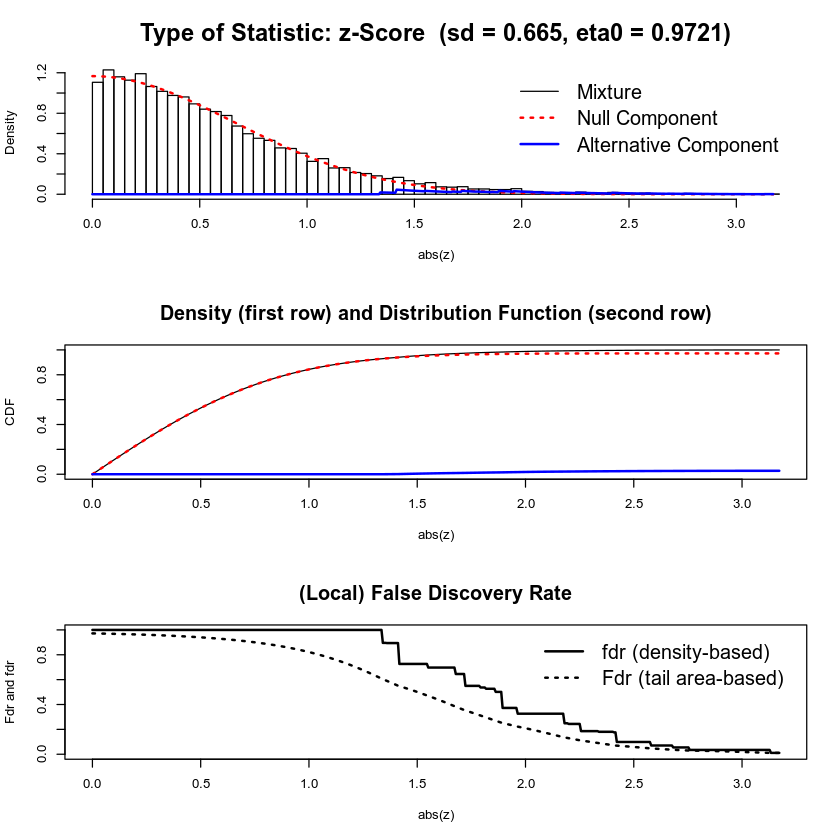

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
ENSG00000134717,74.345400,0.8448438,0.2699645,3.129463,0.001751264,0.01118999,BTF3L4
ENSG00000188283,99.931656,-0.8180370,0.2582666,-3.167413,0.001538016,0.01118999,ZNF383
ENSG00000270170,269.224273,-2.9039838,0.9155347,-3.171899,0.001514455,0.01118999,NCBP2-AS2
ENSG00000088876,128.448362,0.6424090,0.2123886,3.024687,0.002488908,0.01796528,ZNF343
ENSG00000277075,5195.739640,-1.2230821,0.4126848,-2.963720,0.003039452,0.02213519,HIST1H2AE
ENSG00000135482,151.697525,0.6879615,0.2364730,2.909260,0.003622858,0.02694475,ZC3H10
ENSG00000006194,503.119918,-0.3665994,0.1298320,-2.823645,0.004748090,0.03065486,ZNF263
ENSG00000101096,23.146610,1.9426506,0.7054037,2.753956,0.005887975,0.03065486,NFATC2
ENSG00000124635,2025.262014,-1.0369356,0.3741489,-2.771452,0.005580689,0.03065486,HIST1H2BJ


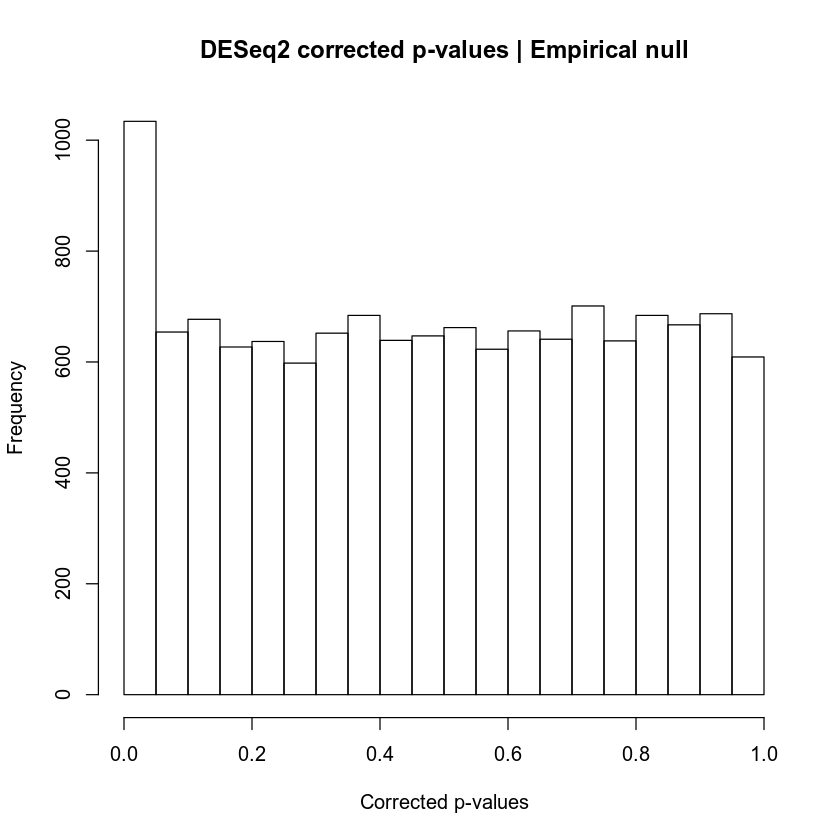

In [4]:
res.t1vst0 <- riborex(rna.read.counts.all, 
                      ribo.read.counts.all, 
                      rna.conditions.all, 
                      ribo.conditions.all, 
                      contrast = contrast.t1vst0)
write_results(res.t1vst0, 'All.Riborex.T1vsT0')

res.t1vst0 <- doPvalueAdjustment(res.t1vst0)
write_results(res.t1vst0, 'All.Riborex.T1vsT0.padjusted')



# All T24 vs T0

DESeq2 mode selected
combining design matrix
applying DESeq2 to modified design matrix
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
ENSG00000180573,4001.8243,-2.4499311,0.27447444,-8.925899,4.420953e-19,2.021702e-15,HIST1H2AC
ENSG00000197903,1549.6575,-2.1785674,0.33124827,-6.576842,4.805463e-11,1.098769e-07,HIST1H2BK
ENSG00000180596,1880.3376,-1.7477242,0.29799451,-5.864954,4.492562e-09,6.848162e-06,HIST1H2BC
ENSG00000124635,2025.2620,-2.1101177,0.37313195,-5.655152,1.557088e-08,1.780141e-05,HIST1H2BJ
ENSG00000158373,2710.7080,-1.9440230,0.34650195,-5.610425,2.018308e-08,1.845944e-05,HIST1H2BD
ENSG00000277075,5195.7396,-2.2739473,0.41795518,-5.440649,5.308692e-08,4.046108e-05,HIST1H2AE
ENSG00000187837,16220.8008,-1.5027186,0.30266139,-4.965016,6.869552e-07,4.487780e-04,HIST1H1C
ENSG00000105373,1150.7020,-0.8138014,0.16894326,-4.817010,1.457253e-06,8.330025e-04,GLTSCR2
ENSG00000100316,16718.1560,-0.4919563,0.10847528,-4.535193,5.755084e-06,2.248697e-03,RPL3


Step 1... determine cutoff point
Step 2... estimate parameters of null distribution and eta0
Step 3... compute p-values and estimate empirical PDF/CDF
Step 4... compute q-values and local fdr
Step 5... prepare for plotting


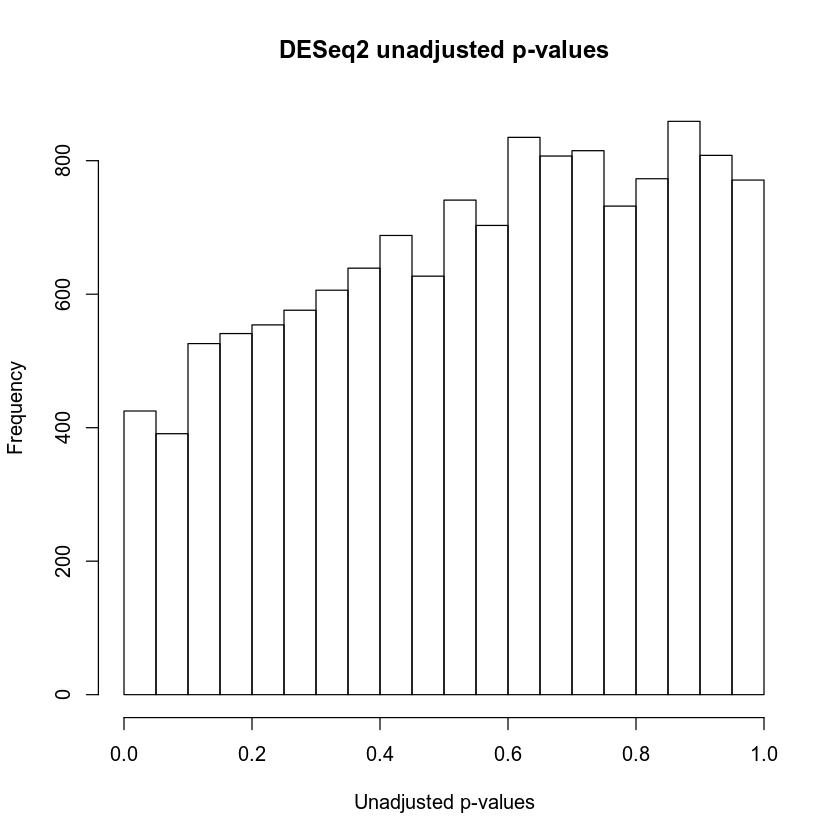

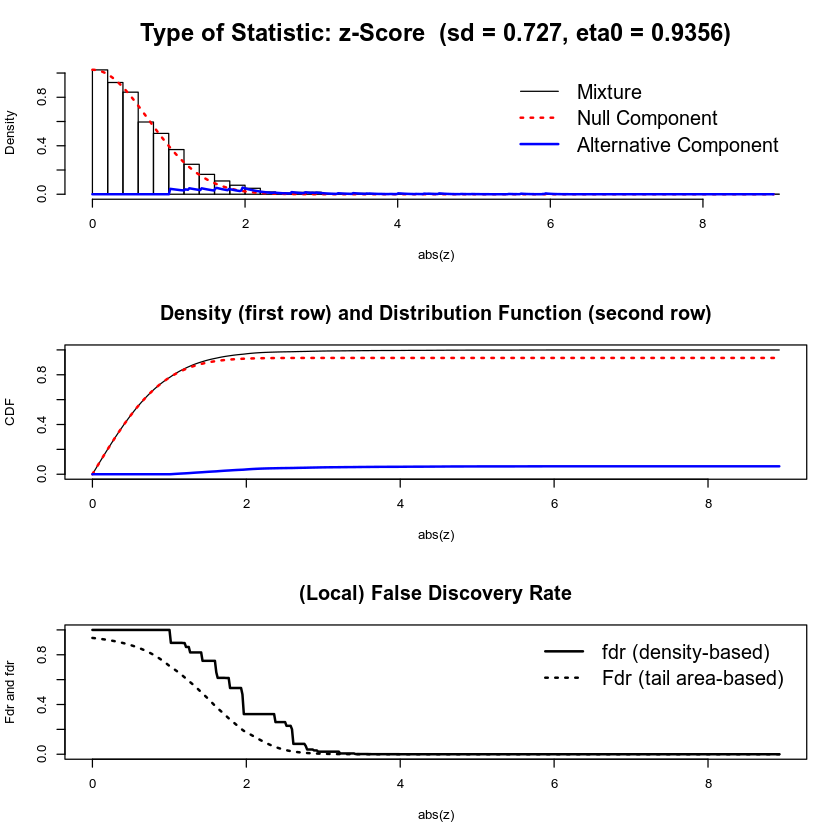

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
ENSG00000180573,4001.8243,-2.4499311,0.27447444,-8.925899,4.420953e-19,5.077050e-13,HIST1H2AC
ENSG00000197903,1549.6575,-2.1785674,0.33124827,-6.576842,4.805463e-11,5.077050e-13,HIST1H2BK
ENSG00000180596,1880.3376,-1.7477242,0.29799451,-5.864954,4.492562e-09,1.015410e-12,HIST1H2BC
ENSG00000124635,2025.2620,-2.1101177,0.37313195,-5.655152,1.557088e-08,8.377132e-12,HIST1H2BJ
ENSG00000158373,2710.7080,-1.9440230,0.34650195,-5.610425,2.018308e-08,1.076335e-11,HIST1H2BD
ENSG00000277075,5195.7396,-2.2739473,0.41795518,-5.440649,5.308692e-08,5.483214e-11,HIST1H2AE
ENSG00000187837,16220.8008,-1.5027186,0.30266139,-4.965016,6.869552e-07,5.544719e-09,HIST1H1C
ENSG00000105373,1150.7020,-0.8138014,0.16894326,-4.817010,1.457253e-06,1.965339e-08,GLTSCR2
ENSG00000174444,14823.8808,-0.3678406,0.08049781,-4.569573,4.887194e-06,1.654290e-07,RPL4


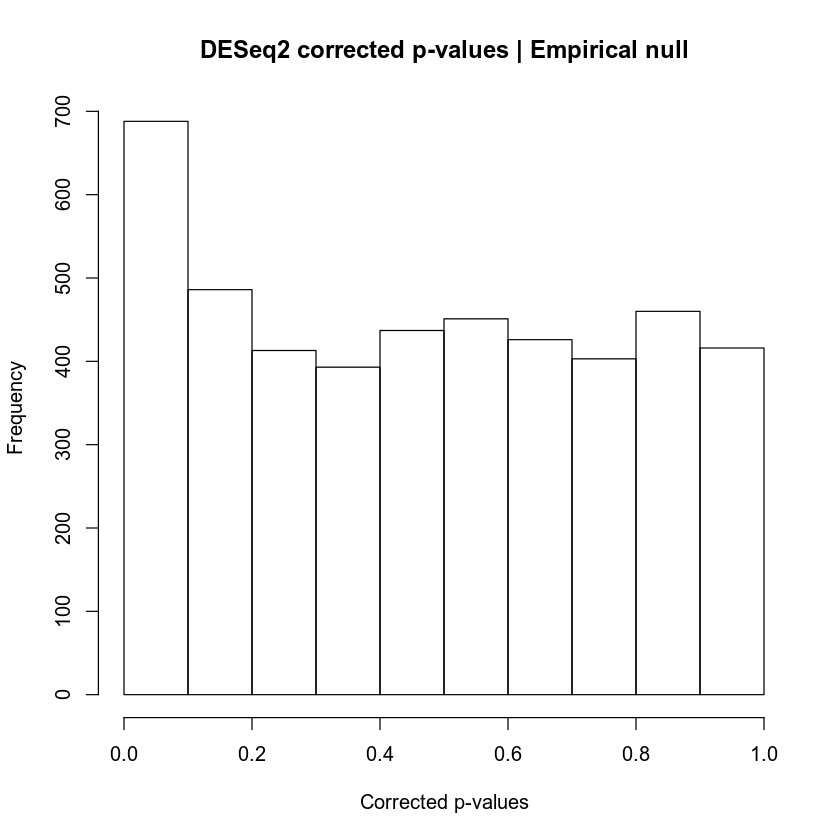

In [5]:
res.t24vst0 <- riborex(rna.read.counts.all, 
                       ribo.read.counts.all, 
                       rna.conditions.all, 
                       ribo.conditions.all, 
                       contrast = contrast.t24vst0)
write_results(res.t24vst0, prefix='All.Riborex.T24vsT0')

res.t24vst0 <- doPvalueAdjustment(res.t24vst0)
write_results(res.t24vst0, 'All.Riborex.T24vsT0.padjusted')


# All T24 vs T1 

DESeq2 mode selected
combining design matrix
applying DESeq2 to modified design matrix
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
ENSG00000274750,134.7520,-2.4606897,0.36102125,-6.815914,9.366644e-12,1.207922e-07,HIST1H3E
ENSG00000180573,4001.8243,-1.6742513,0.26051916,-6.426596,1.304932e-10,8.414201e-07,HIST1H2AC
ENSG00000197903,1549.6575,-1.9629789,0.31494784,-6.232711,4.584316e-10,1.970645e-06,HIST1H2BK
ENSG00000134419,4301.5677,-0.5715225,0.09926212,-5.757710,8.526289e-09,2.748876e-05,RPS15A
ENSG00000180596,1880.3376,-1.5361037,0.28429576,-5.403189,6.546639e-08,1.688509e-04,HIST1H2BC
ENSG00000105373,1150.7020,-0.7902844,0.16036848,-4.927929,8.310587e-07,1.786222e-03,GLTSCR2
ENSG00000158373,2710.7080,-1.5852858,0.32952272,-4.810854,1.502865e-06,2.768707e-03,HIST1H2BD
ENSG00000204628,33668.9537,-0.3375473,0.07102263,-4.752673,2.007451e-06,3.236011e-03,RACK1
ENSG00000167996,5506.8534,1.2553510,0.27094447,4.633241,3.599852e-06,5.158188e-03,FTH1


Step 1... determine cutoff point
Step 2... estimate parameters of null distribution and eta0
Step 3... compute p-values and estimate empirical PDF/CDF
Step 4... compute q-values and local fdr
Step 5... prepare for plotting


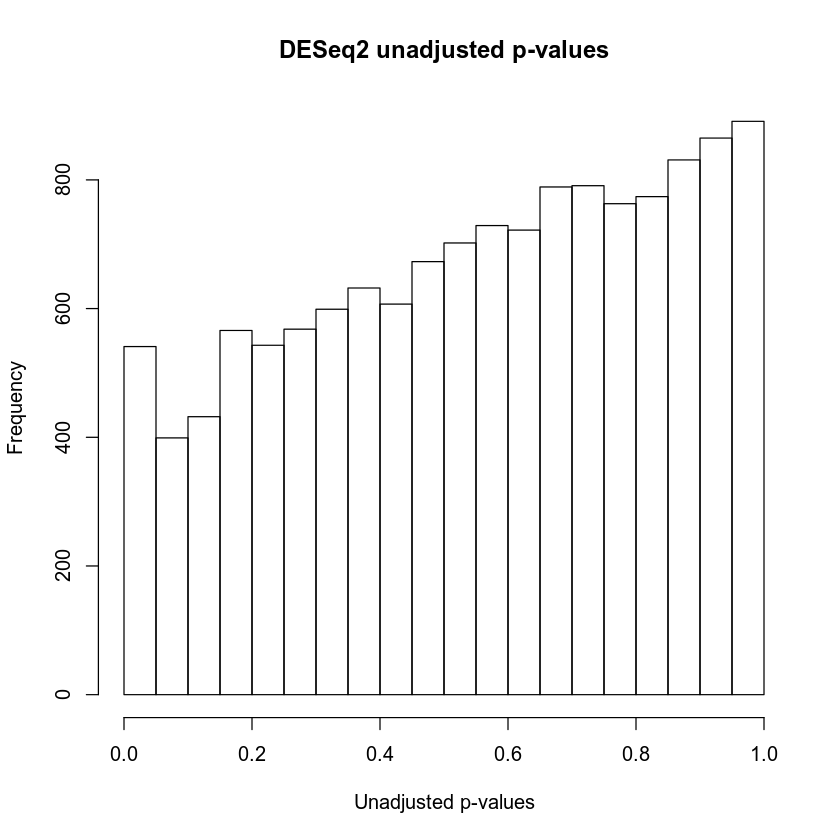

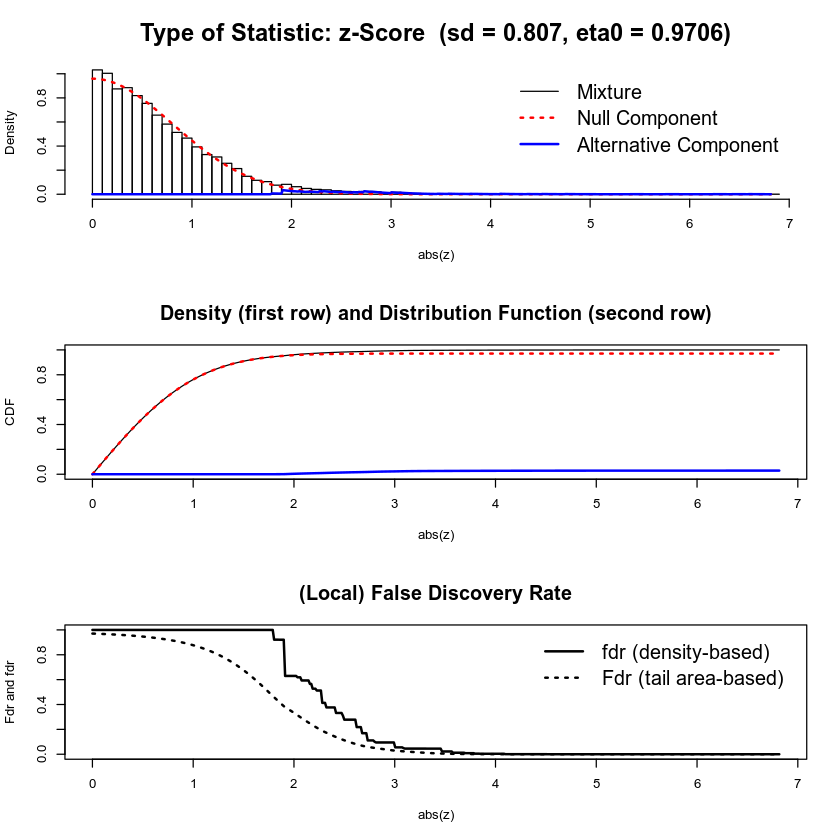

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
ENSG00000274750,134.75201,-2.4606897,0.36102125,-6.815914,9.366644e-12,2.863487e-12,HIST1H3E
ENSG00000180573,4001.82434,-1.6742513,0.26051916,-6.426596,1.304932e-10,1.145395e-11,HIST1H2AC
ENSG00000197903,1549.65750,-1.9629789,0.31494784,-6.232711,4.584316e-10,4.963378e-11,HIST1H2BK
ENSG00000134419,4301.56769,-0.5715225,0.09926212,-5.757710,8.526289e-09,3.177755e-09,RPS15A
ENSG00000180596,1880.33763,-1.5361037,0.28429576,-5.403189,6.546639e-08,5.626237e-08,HIST1H2BC
ENSG00000105373,1150.70196,-0.7902844,0.16036848,-4.927929,8.310587e-07,2.215125e-06,GLTSCR2
ENSG00000158373,2710.70804,-1.5852858,0.32952272,-4.810854,1.502865e-06,4.659273e-06,HIST1H2BD
ENSG00000204628,33668.95374,-0.3375473,0.07102263,-4.752673,2.007451e-06,6.320613e-06,RACK1
ENSG00000167996,5506.85342,1.2553510,0.27094447,4.633241,3.599852e-06,1.360268e-05,FTH1


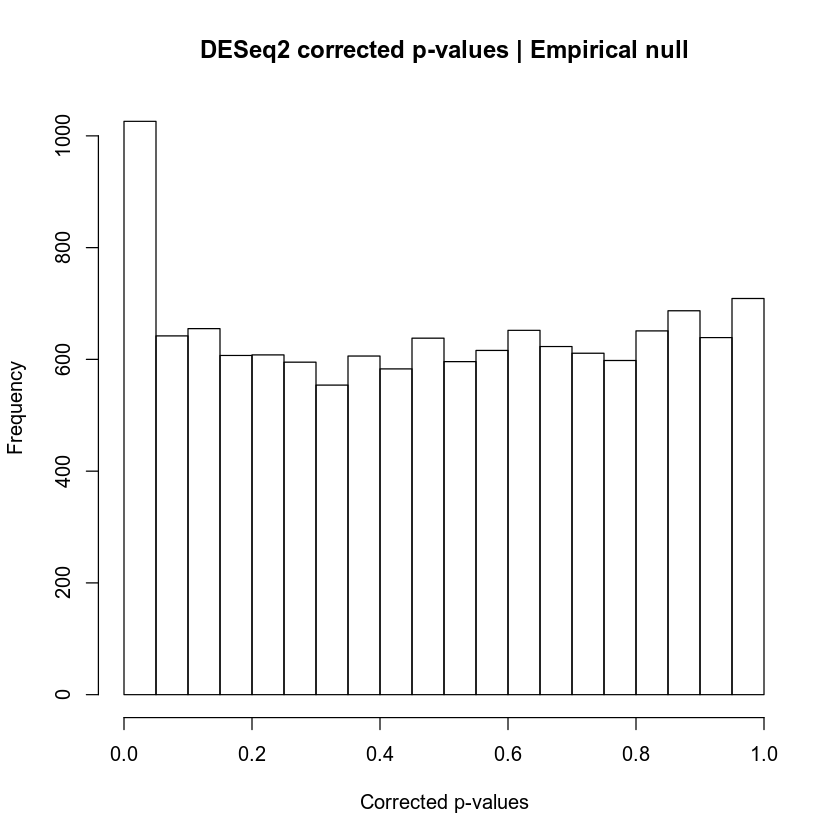

In [6]:
res.t24vst1 <- riborex(rna.read.counts.all, 
                       ribo.read.counts.all, 
                       rna.conditions.all, 
                       ribo.conditions.all, 
                       contrast = contrast.t24vst1)
write_results(res.t24vst1, prefix='All.Riborex.T24vsT1')

res.t24vst1 <- doPvalueAdjustment(res.t24vst1)
write_results(res.t24vst1, 'All.Riborex.T24vsT1.padjusted')


# All T24 vs (T1+T0)

DESeq2 mode selected
combining design matrix
applying DESeq2 to modified design matrix
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
ENSG00000180573,4001.8243,-2.0260434,0.26976716,-7.510341,5.897346e-14,2.345669e-10,HIST1H2AC
ENSG00000197903,1549.6575,-2.0632063,0.27357483,-7.541652,4.640530e-14,2.345669e-10,HIST1H2BK
ENSG00000180596,1880.3376,-1.6316428,0.25491558,-6.400718,1.546477e-10,4.100742e-07,HIST1H2BC
ENSG00000158373,2710.7080,-1.7511824,0.29189004,-5.999459,1.979755e-09,3.937239e-06,HIST1H2BD
ENSG00000105373,1150.7020,-0.8005130,0.13992887,-5.720856,1.059885e-08,1.648784e-05,GLTSCR2
ENSG00000134419,4301.5677,-0.5034936,0.08843087,-5.693641,1.243583e-08,1.648784e-05,RPS15A
ENSG00000133112,23723.3200,-0.5651038,0.10809306,-5.227938,1.714110e-07,1.947964e-04,TPT1
ENSG00000204628,33668.9537,-0.3317349,0.06409419,-5.175742,2.270075e-07,2.257306e-04,RACK1
ENSG00000174444,14823.8808,-0.3375096,0.06549221,-5.153432,2.557621e-07,2.260653e-04,RPL4


Step 1... determine cutoff point
Step 2... estimate parameters of null distribution and eta0
Step 3... compute p-values and estimate empirical PDF/CDF
Step 4... compute q-values and local fdr
Step 5... prepare for plotting


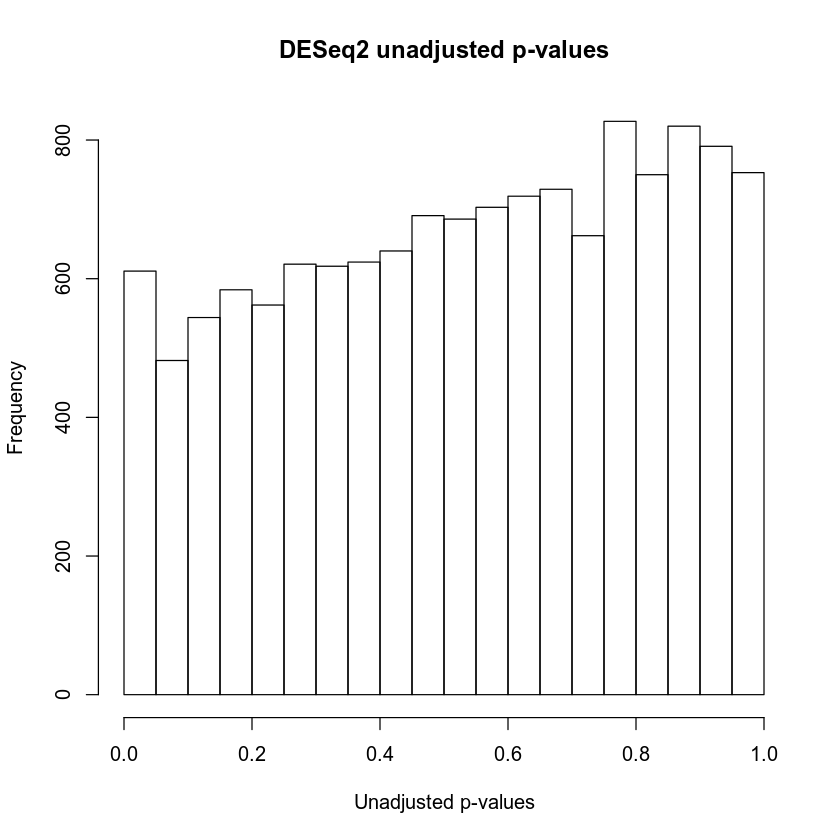

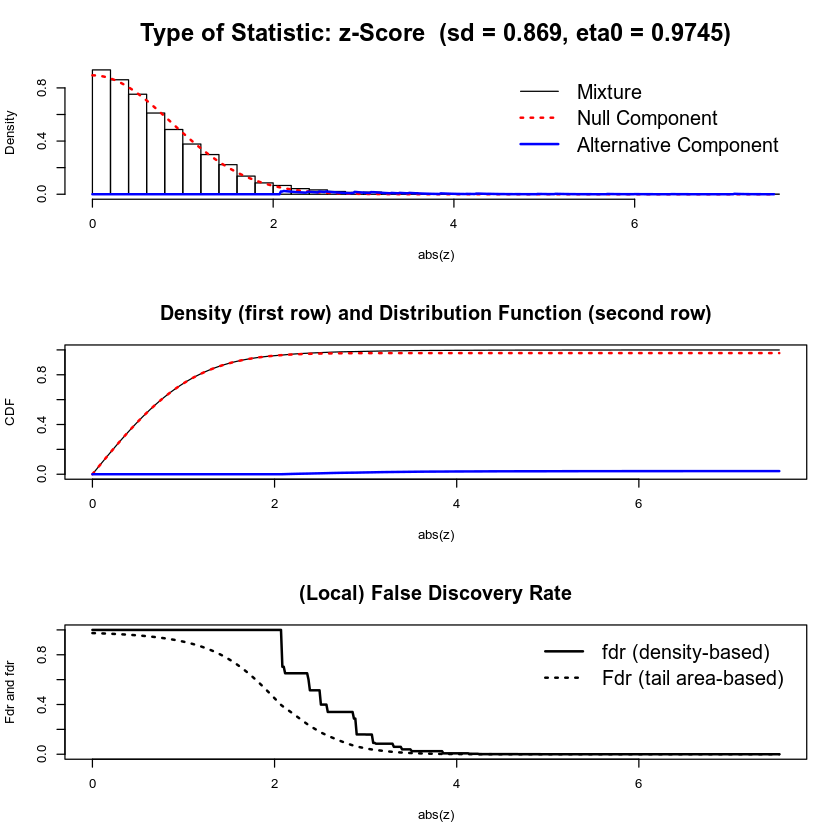

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
ENSG00000180573,4001.8243,-2.0260434,0.26976716,-7.510341,5.897346e-14,8.831824e-13,HIST1H2AC
ENSG00000197903,1549.6575,-2.0632063,0.27357483,-7.541652,4.640530e-14,8.831824e-13,HIST1H2BK
ENSG00000180596,1880.3376,-1.6316428,0.25491558,-6.400718,1.546477e-10,4.751521e-10,HIST1H2BC
ENSG00000158373,2710.7080,-1.7511824,0.29189004,-5.999459,1.979755e-09,1.020782e-08,HIST1H2BD
ENSG00000105373,1150.7020,-0.8005130,0.13992887,-5.720856,1.059885e-08,7.417213e-08,GLTSCR2
ENSG00000134419,4301.5677,-0.5034936,0.08843087,-5.693641,1.243583e-08,7.626398e-08,RPS15A
ENSG00000133112,23723.3200,-0.5651038,0.10809306,-5.227938,1.714110e-07,2.053275e-06,TPT1
ENSG00000204628,33668.9537,-0.3317349,0.06409419,-5.175742,2.270075e-07,2.598109e-06,RACK1
ENSG00000174444,14823.8808,-0.3375096,0.06549221,-5.153432,2.557621e-07,2.700923e-06,RPL4


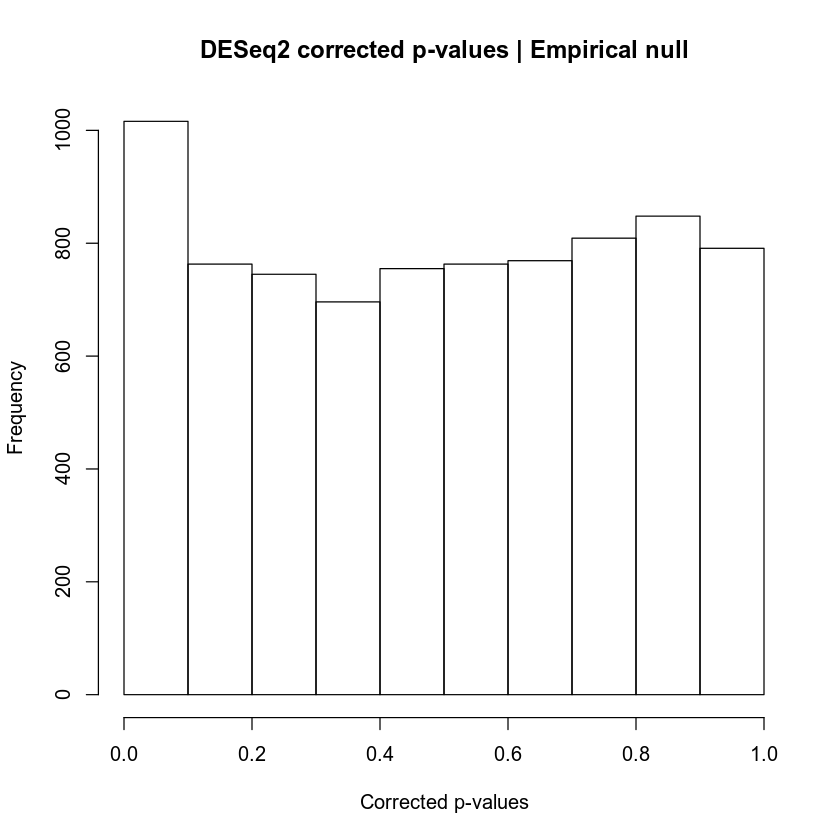

In [7]:
res.t24vst0t1 <- riborex(rna.read.counts.all, 
                         ribo.read.counts.all, 
                         rna.conditions.all.t0t1, 
                         ribo.conditions.all.t0t1, 
                         contrast = contrast.t24vst0t1)
write_results(res.t24vst0t1, prefix='All.Riborex.T24vsT0T1')

res.t24vst0t1 <- doPvalueAdjustment(res.t24vst0t1)
write_results(res.t24vst0t1, 'All.Riborex.T24vsT0T1.padjusted')
